In [1]:
from preprocessing import load_reviews
from concepts import ConceptExtractor, conceptualize_df, visualize_concept_wordcloud
from experiments import run_experiment
from features import SentimentFeatures
import numpy as np
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
import random

[nltk_data] Downloading package punkt to /home/janek/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
2025-11-27 22:46:20.410550: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Setup

In [2]:
num_concepts = 3000
num_important_features = int(num_concepts * 0.2)

seed = 42

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
train_df, test_df, val_df = load_reviews("word")
train_df.head()

INFO:absl:No config specified, defaulting to config: imdb_reviews/plain_text
INFO:absl:Load dataset info from /home/janek/tensorflow_datasets/imdb_reviews/plain_text/1.0.0
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /home/janek/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.
I0000 00:00:1764279984.563271    1596 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3584 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
INFO:absl:Constructing tf.data.Dataset imdb_reviews for split train, from /home/janek/tensorflow_datasets/imdb_reviews/plain_text/1.0.0
INFO:absl:No config specified, defaulting to config: imdb_reviews/plain_text
INFO:absl:Load dataset info from /home/janek/tensorflow_datasets/imdb_reviews/plain_text/1.0.0
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /home/janek/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.
IN

,review,sentiment,units
0,This was an absolutely terrible movie. Don't b...,0,"[this, was, an, absolutely, terrible, movie, d..."
1,"I have been known to fall asleep during films,...",0,"[i, have, been, known, to, fall, asleep, durin..."
2,Mann photographs the Alberta Rocky Mountains i...,0,"[mann, photographs, the, alberta, rocky, mount..."
3,This is the kind of film for a snowy Sunday af...,1,"[this, is, the, kind, of, film, for, a, snowy,..."
4,"As others have mentioned, all the women that g...",1,"[as, others, have, mentioned, all, the, women,..."


# Concepts

In [4]:
extractor = ConceptExtractor()
concepts = extractor.train_concepts(train_df["units"].explode().tolist() , num_concepts)

INFO:concepts:Using device: cuda
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda:0
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2
INFO:concepts:Found 74127 unique units.
INFO:concepts:Computing embeddings...


Batches:   0%|          | 0/73 [00:00<?, ?it/s]

INFO:concepts:Clustering 74127 embeddings into 3000 concepts using FAISS...
WARNING clustering 74127 points to 3000 centroids: please provide at least 117000 training points


Clustering 74127 points in 384D to 3000 clusters, redo 1 times, 25 iterations
  Preprocessing in 0.01 s
  Iteration 24 (1.48 s, search 1.28 s): objective=33308.8 imbalance=1.396 nsplit=0       


INFO:concepts:Concept training completed!


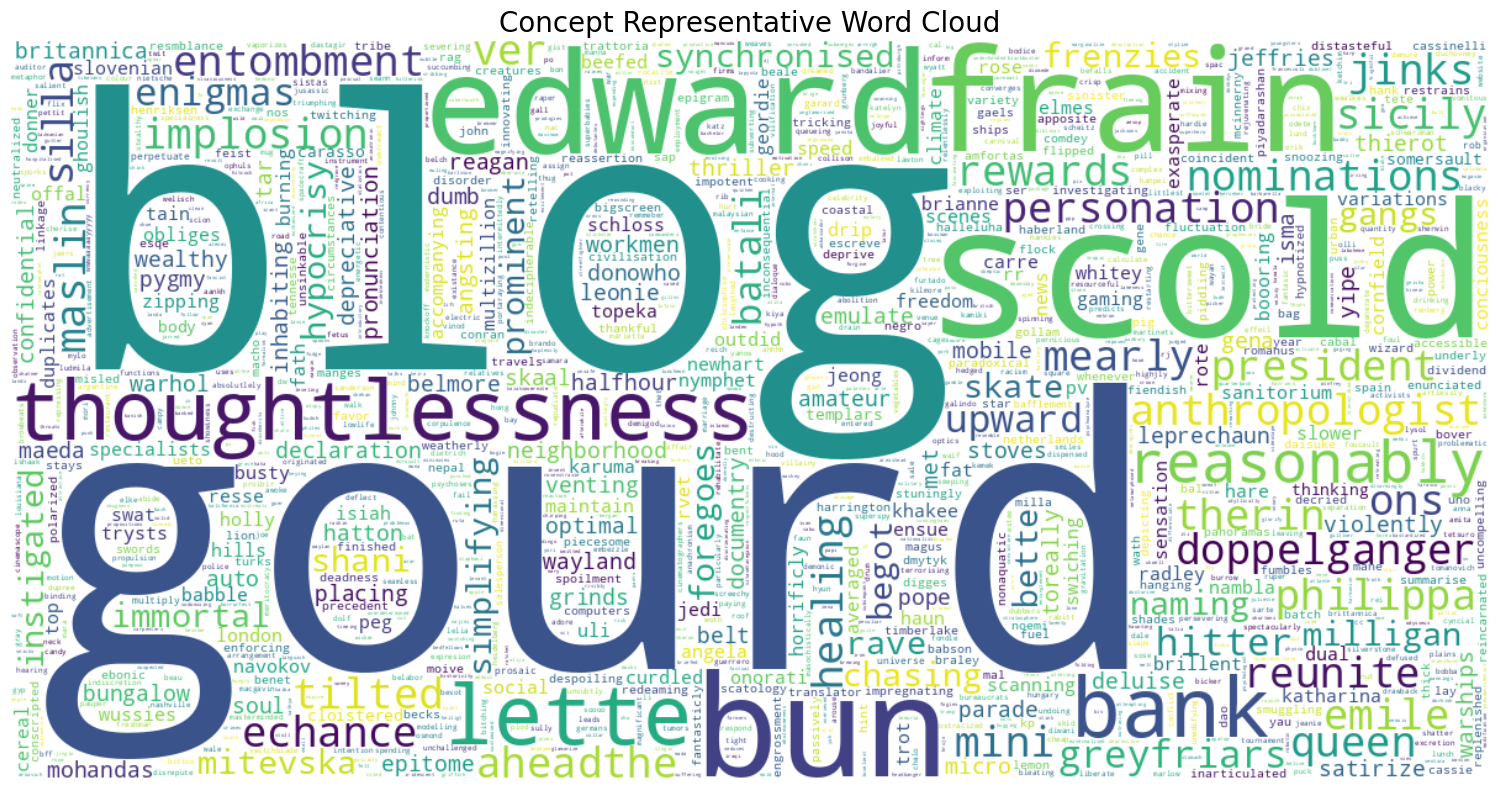

In [5]:
visualize_concept_wordcloud(concepts["concept_units"], num_concepts)

In [6]:
conceptualize_df(train_df, "units", concepts["unit_to_cluster"])
train_df.head()

,review,sentiment,units,concept_ids
0,This was an absolutely terrible movie. Don't b...,0,"[this, was, an, absolutely, terrible, movie, d...","[1276, 311, 1777, 917, 2225, 1798, 725, 917, 5..."
1,"I have been known to fall asleep during films,...",0,"[i, have, been, known, to, fall, asleep, durin...","[1020, 1884, 548, 404, 148, 975, 1509, 1384, 2..."
2,Mann photographs the Alberta Rocky Mountains i...,0,"[mann, photographs, the, alberta, rocky, mount...","[675, 2647, 1936, 1662, 1096, 116, 679, 1777, ..."
3,This is the kind of film for a snowy Sunday af...,1,"[this, is, the, kind, of, film, for, a, snowy,...","[1276, 311, 1936, 325, 1884, 2155, 2069, 1777,..."
4,"As others have mentioned, all the women that g...",1,"[as, others, have, mentioned, all, the, women,...","[2400, 2218, 1884, 1464, 477, 1936, 1221, 1276..."


In [7]:
# Map test words
test_unit_map = extractor.map_units_to_clusters(train_df["units"].explode().tolist(), concepts["cluster_centers"])

INFO:concepts:Mapping 74127 units to nearest clusters...


Batches:   0%|          | 0/73 [00:00<?, ?it/s]

In [8]:
conceptualize_df(test_df, "units", test_unit_map)
test_df.head()

,review,sentiment,units,concept_ids
15072,The latest film by the Spanish director Agusti...,1,"[the, latest, film, by, the, spanish, director...","[1936, 1524, 2155, 2543, 1936, 231, 557, 2174,..."
9987,"As others have mentioned, this movie is simila...",0,"[as, others, have, mentioned, this, movie, is,...","[2400, 2218, 2133, 1464, 1276, 1798, 311, 1108..."
24558,"I have no idea how to describe this movie, and...",1,"[i, have, no, idea, how, to, describe, this, m...","[1276, 2133, 917, 1417, 1623, 2988, 806, 1276,..."
2571,"Ah, I loved this movie. I think it had it all....",1,"[ah, i, loved, this, movie, i, think, it, had,...","[1163, 1276, 2795, 1276, 1798, 1276, 196, 1276..."
16059,Brilliant movie. The drawings were just amazin...,1,"[brilliant, movie, the, drawings, were, just, ...","[1031, 1798, 1936, 2082, 311, 1537, 364, 1596,..."


# Feature selection

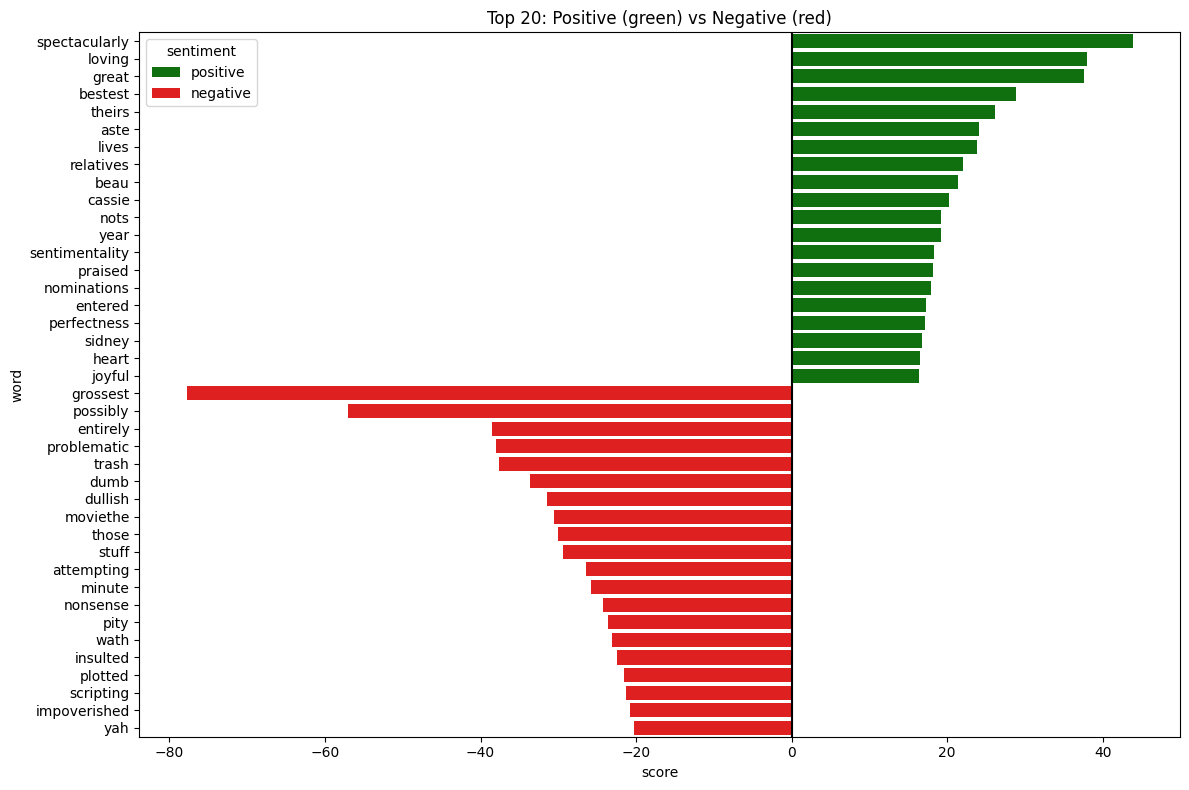

In [9]:
an = SentimentFeatures()
an.fit(train_df["concept_ids"], train_df["sentiment"])

an.plot_top(concepts["concept_units"])

In [10]:
train_df = an.add_top_features(train_df, n=num_important_features)
test_df  = an.add_top_features(test_df, n=num_important_features)

# Models

In [11]:
train_df.head()

,review,sentiment,units,concept_ids,concept_ids_positive_features,concept_ids_negative_features,concept_ids_important_features
0,This was an absolutely terrible movie. Don't b...,0,"[this, was, an, absolutely, terrible, movie, d...","[1276, 311, 1777, 917, 2225, 1798, 725, 917, 5...","[1777, 679, 1803, 2511, 1911, 1596, 2377, 1176...","[1276, 311, 917, 2225, 1798, 725, 917, 548, 19...","[1276, 311, 1777, 917, 2225, 1798, 725, 917, 5..."
1,"I have been known to fall asleep during films,...",0,"[i, have, been, known, to, fall, asleep, durin...","[1020, 1884, 548, 404, 148, 975, 1509, 1384, 2...","[1384, 2155, 1596, 1777, 463, 1596, 1596, 1936...","[1020, 548, 148, 975, 1509, 1276, 311, 442, 21...","[1020, 548, 148, 975, 1509, 1384, 2155, 1596, ..."
2,Mann photographs the Alberta Rocky Mountains i...,0,"[mann, photographs, the, alberta, rocky, mount...","[675, 2647, 1936, 1662, 1096, 116, 679, 1777, ...","[675, 2647, 1936, 1096, 679, 1777, 2380, 1596,...","[752, 1276, 917, 148, 725, 2295, 505, 2540, 19...","[675, 2647, 1936, 1096, 679, 1777, 2380, 752, ..."
3,This is the kind of film for a snowy Sunday af...,1,"[this, is, the, kind, of, film, for, a, snowy,...","[1276, 311, 1936, 325, 1884, 2155, 2069, 1777,...","[1936, 2155, 1777, 235, 1936, 1936, 777, 1384,...","[1276, 311, 1194, 917, 2612, 1276, 477, 148, 6...","[1276, 311, 1936, 2155, 1777, 235, 1936, 1194,..."
4,"As others have mentioned, all the women that g...",1,"[as, others, have, mentioned, all, the, women,...","[2400, 2218, 1884, 1464, 477, 1936, 1221, 1276...","[2400, 2218, 1936, 679, 2155, 433, 1936, 6, 14...","[1464, 477, 1276, 2612, 2587, 1276, 311, 442, ...","[2400, 2218, 1464, 477, 1936, 1276, 2612, 2587..."


# TF-IDF

In [12]:
y_train = train_df["sentiment"]
y_test = test_df["sentiment"]

In [13]:
train_df["concept_ids"] = train_df["concept_ids"].apply(
    lambda x: " ".join(str(id) for id in x)
)
train_df.head()

train_df["concept_ids_positive_features"] = train_df["concept_ids_positive_features"].apply(
    lambda x: " ".join(str(id) for id in x)
)
train_df.head()

train_df["concept_ids_negative_features"] = train_df["concept_ids_negative_features"].apply(
    lambda x: " ".join(str(id) for id in x)
)
train_df.head()

train_df["concept_ids_important_features"] = train_df["concept_ids_important_features"].apply(
    lambda x: " ".join(str(id) for id in x)
)
train_df.head()

,review,sentiment,units,concept_ids,concept_ids_positive_features,concept_ids_negative_features,concept_ids_important_features
0,This was an absolutely terrible movie. Don't b...,0,"[this, was, an, absolutely, terrible, movie, d...",1276 311 1777 917 2225 1798 725 917 548 949 67...,1777 679 1803 2511 1911 1596 2377 1176 2040 67...,1276 311 917 2225 1798 725 917 548 1954 1954 3...,1276 311 1777 917 2225 1798 725 917 548 679 18...
1,"I have been known to fall asleep during films,...",0,"[i, have, been, known, to, fall, asleep, durin...",1020 1884 548 404 148 975 1509 1384 2155 1596 ...,1384 2155 1596 1777 463 1596 1596 1936 1596 17...,1020 548 148 975 1509 1276 311 442 2138 148 13...,1020 548 148 975 1509 1384 2155 1596 1276 311 ...
2,Mann photographs the Alberta Rocky Mountains i...,0,"[mann, photographs, the, alberta, rocky, mount...",675 2647 1936 1662 1096 116 679 1777 2380 752 ...,675 2647 1936 1096 679 1777 2380 1596 580 420 ...,752 1276 917 148 725 2295 505 2540 1988 148 91...,675 2647 1936 1096 679 1777 2380 752 1596 580 ...
3,This is the kind of film for a snowy Sunday af...,1,"[this, is, the, kind, of, film, for, a, snowy,...",1276 311 1936 325 1884 2155 2069 1777 944 2134...,1936 2155 1777 235 1936 1936 777 1384 2669 117...,1276 311 1194 917 2612 1276 477 148 687 1648 7...,1276 311 1936 2155 1777 235 1936 1194 1936 777...
4,"As others have mentioned, all the women that g...",1,"[as, others, have, mentioned, all, the, women,...",2400 2218 1884 1464 477 1936 1221 1276 2612 25...,2400 2218 1936 679 2155 433 1936 6 1492 1936 1...,1464 477 1276 2612 2587 1276 311 442 917 1648 ...,2400 2218 1464 477 1936 1276 2612 2587 679 127...


In [14]:
test_df["concept_ids"] = test_df["concept_ids"].apply(
    lambda x: " ".join(str(id) for id in x)
)
test_df.head()

test_df["concept_ids_positive_features"] = test_df["concept_ids_positive_features"].apply(
    lambda x: " ".join(str(id) for id in x)
)
test_df.head()

test_df["concept_ids_negative_features"] = test_df["concept_ids_negative_features"].apply(
    lambda x: " ".join(str(id) for id in x)
)
test_df.head()

test_df["concept_ids_important_features"] = test_df["concept_ids_important_features"].apply(
    lambda x: " ".join(str(id) for id in x)
)
test_df.head()

,review,sentiment,units,concept_ids,concept_ids_positive_features,concept_ids_negative_features,concept_ids_important_features
15072,The latest film by the Spanish director Agusti...,1,"[the, latest, film, by, the, spanish, director...",1936 1524 2155 2543 1936 231 557 2174 2896 311...,1936 1524 2155 1936 231 2896 1777 757 1144 159...,311 2295 1276 2072 148 1813 1276 1172 520 1954...,1936 1524 2155 1936 231 2896 311 1777 2295 757...
9987,"As others have mentioned, this movie is simila...",0,"[as, others, have, mentioned, this, movie, is,...",2400 2218 2133 1464 1276 1798 311 1108 2988 19...,2400 2218 1108 1936 1524 1596 1936 1078 2778 1...,1464 1276 1798 311 779 1954 1701 311 1276 1276...,2400 2218 1464 1276 1798 311 1108 1936 779 195...
24558,"I have no idea how to describe this movie, and...",1,"[i, have, no, idea, how, to, describe, this, m...",1276 2133 917 1417 1623 2988 806 1276 1798 159...,1596 1596 2795 1359 2218 1936 2669 1835 364 15...,1276 917 1417 1276 1798 917 1420 1276 1276 917...,1276 917 1417 1276 1798 1596 1596 917 2795 135...
2571,"Ah, I loved this movie. I think it had it all....",1,"[ah, i, loved, this, movie, i, think, it, had,...",1163 1276 2795 1276 1798 1276 196 1276 2133 12...,2795 2925 1777 1777 1596 1777 1103 2776 1777 2...,1163 1276 1276 1798 1276 196 1276 1276 477 127...,1163 1276 2795 1276 1798 1276 196 1276 1276 47...
16059,Brilliant movie. The drawings were just amazin...,1,"[brilliant, movie, the, drawings, were, just, ...",1031 1798 1936 2082 311 1537 364 1596 2225 127...,1031 1936 364 1596 1384 255 1777 1596,1798 311 1537 2225 1276 335 1276 1814 1276 848...,1031 1798 1936 311 1537 364 1596 2225 1276 335...


In [15]:
# Main concept IDs
tfidf_main = TfidfVectorizer(max_features=50000, ngram_range=(1, 3), min_df=2, max_df=0.8)
X_all_train = tfidf_main.fit_transform(train_df["concept_ids"])
X_all_test  = tfidf_main.transform(test_df["concept_ids"])

# Positive features
tfidf_pos = TfidfVectorizer(max_features=50000, ngram_range=(1, 3), min_df=2, max_df=0.8)
X_pos_train = tfidf_pos.fit_transform(train_df["concept_ids_positive_features"])
X_pos_test  = tfidf_pos.transform(test_df["concept_ids_positive_features"])

# Negative features
tfidf_neg = TfidfVectorizer(max_features=50000, ngram_range=(1, 3), min_df=2, max_df=0.8)
X_neg_train = tfidf_neg.fit_transform(train_df["concept_ids_negative_features"])
X_neg_test  = tfidf_neg.transform(test_df["concept_ids_negative_features"])

# Important features
tfidf_imp = TfidfVectorizer(max_features=50000, ngram_range=(1, 3), min_df=2, max_df=0.8)
X_imp_train = tfidf_neg.fit_transform(train_df["concept_ids_important_features"])
X_imp_test = tfidf_neg.transform(test_df["concept_ids_important_features"])

In [17]:
# Prepare data in the required dictionary format
X_sets_train = {
    'all': X_all_train,
    'pos': X_pos_train, 
    'neg': X_neg_train,
    'important': X_imp_train
}

X_sets_test = {
    'all': X_all_test,
    'pos': X_pos_test,
    'neg': X_neg_test,
    'important': X_imp_test
}

# Verify shapes
print("\nData shapes:")
for key in X_sets_train:
    print(f"Train {key}: {X_sets_train[key].shape}")
for key in X_sets_test:
    print(f"Test {key}: {X_sets_test[key].shape}")

print(f"\nLabel shapes: y_train {y_train.shape}, y_test {y_test.shape}")


Data shapes:
Train all: (25000, 50000)
Train pos: (25000, 50000)
Train neg: (25000, 50000)
Train important: (25000, 50000)
Test all: (20000, 50000)
Test pos: (20000, 50000)
Test neg: (20000, 50000)
Test important: (20000, 50000)

Label shapes: y_train (25000,), y_test (20000,)


## Linear-SVM

LinearSVM 'all' initialized with C=1.0
LinearSVM 'all' trained.

=== ALL EVALUATION ===
Accuracy: 0.9460
              precision    recall  f1-score   support

           0     0.9229    0.9734    0.9475     10000
           1     0.9719    0.9187    0.9445     10000

    accuracy                         0.9460     20000
   macro avg     0.9474    0.9461    0.9460     20000
weighted avg     0.9474    0.9460    0.9460     20000


=== ALL MODEL ===
Accuracy: 0.9460


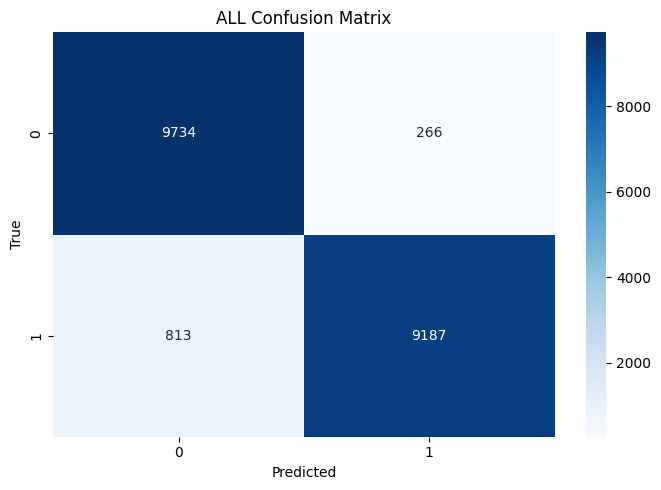

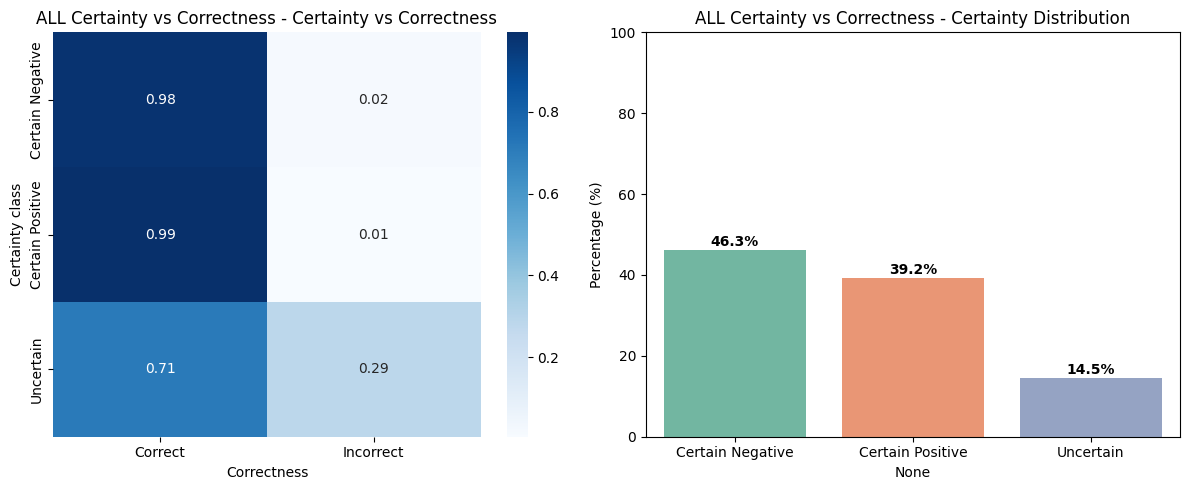


ALL MODEL - Unsure Predictions (probability near 0.3-0.7):
Probability [0.64], Label [1]: "Ah, I loved this movie. I think it had it all. It made me laugh out loud over a dozen of times. Yes, I am a girl, so I'm writing this from a girl's perspective. I think it's a shame it only scored 5.2 in rating. Too many guys voting? It was far above other romantic comedies. Just because I'm female I don't enjoy all chic flicks, on the contrary I prefer other genres. Romantic comedies tend to be shallow and not as funny as they meant to be. But like I said, this movie had it all, almost, in my opinion. Great script, good one-liners, fine acting. Although Eva Longoria Parker's character reminded very much of Gabrielle from Desperate Housewives, but so what? It was awesome. I will keep this film for rainy days, days when I feel low and need a few laughs."
Probability [0.68], Label [1]: "I got a good laugh reading all the idiotic comments for this film,<br /><br />as it's obvious that those people 

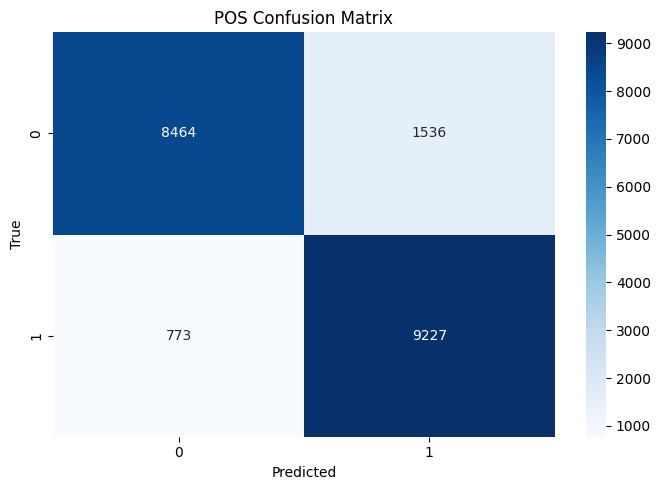

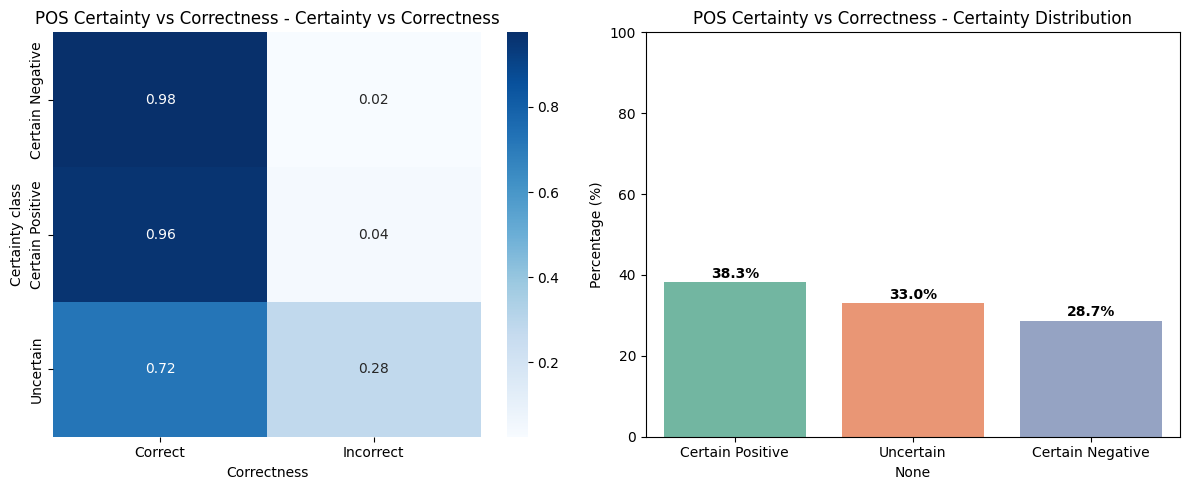


POS MODEL - Unsure Predictions (probability near 0.3-0.7):
Probability [0.48], Label [0]: "As others have mentioned, this movie is similar to THE FLY (both versions) and the lesser known sci-fi flick ALTERED STATES. The big difference is that those two movies were well made by people who knew what they were doing and were good at it. METAMORPHOSIS did not have these advantages. METAMORPHOSIS is a potentially interesting science fantasy story that had the wrong people in charge of it and the wrong actors playing the roles.<br /><br />The story follows scientist Dr. Peter Houseman (Gene LeBrock), an obsessed man working on a genetic cure to aging and death. When the university he works for threatens to cut funding, he decides to inject the anti-aging serum into himself. As a result, Dr. Houseman spends the rest of the movie slowly turning into a lizard. And oh yes, watching the good doctor go through the process of becoming that lizard is a great joy. It really is so bad that it's good.

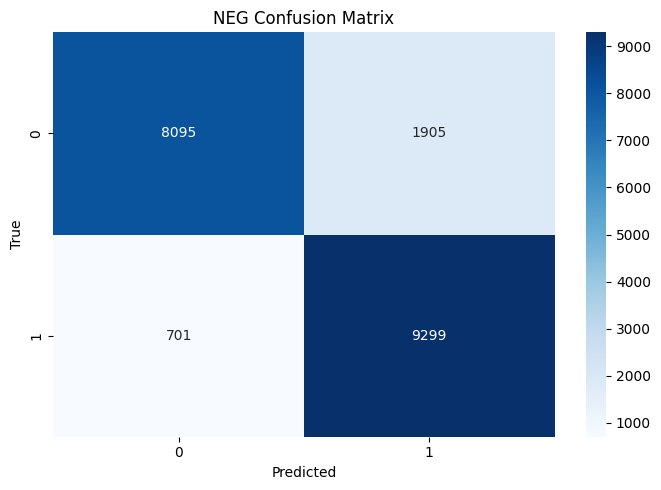

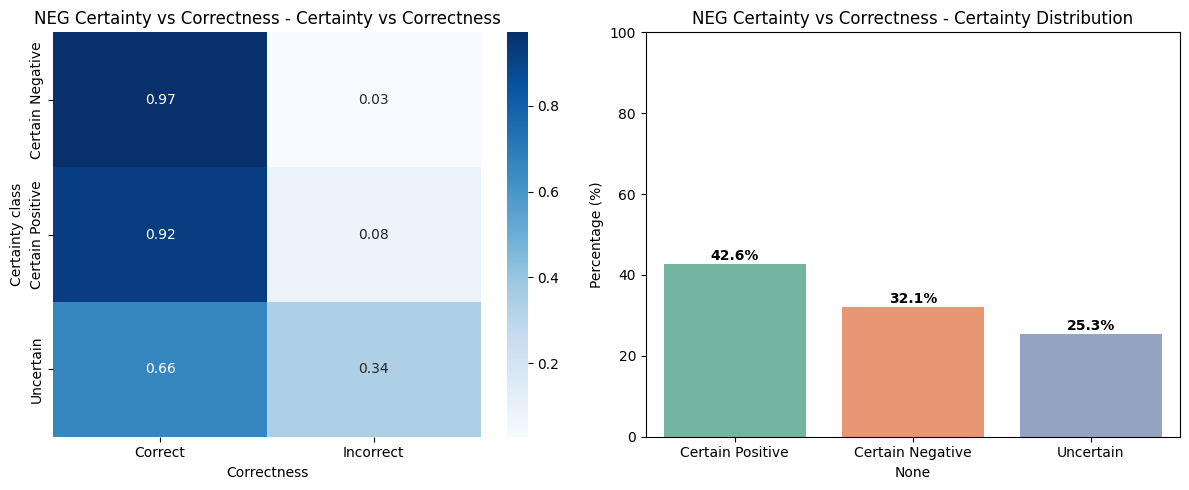


NEG MODEL - Unsure Predictions (probability near 0.3-0.7):
Probability [0.43], Label [1]: "I have no idea how to describe this movie, and also would love to provide others the same opportunity I had - seeing it with no prior knowledge of what to expect. I enjoyed it immensely but can also say I barely understood what was going on, if in fact there was anything to understand in the first place. Fans of David Lynch (tangentially) or especially Guy Maddin films should particularly enjoy this, and any fans of the comic book EIGHTBALL will probably be beside themselves with joy and wonder (it came as close as any film I've seen to the tone and mood Dan Clowes creates so effectively).<br /><br />One slight note just to warn anyone easily offended - this movie, if rated, would be NC-17 for sure. Fans of male full-frontal nudity, however...hmm, well...yes. This is weird wild stuff."
Probability [0.58], Label [1]: "Christopher Lloyd is funny and really believable as "Al the head angel". This m

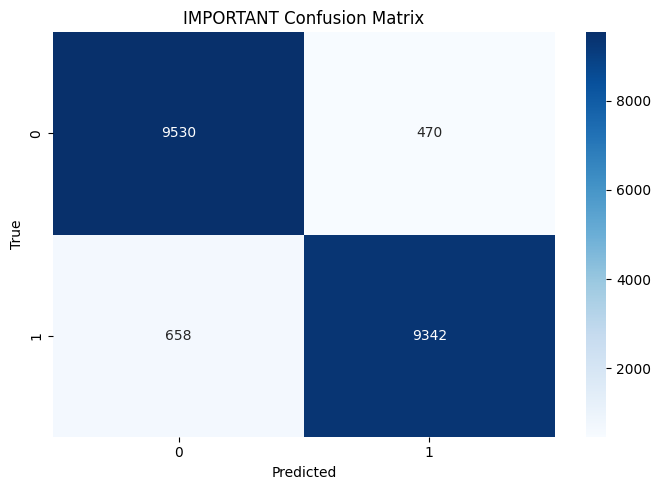

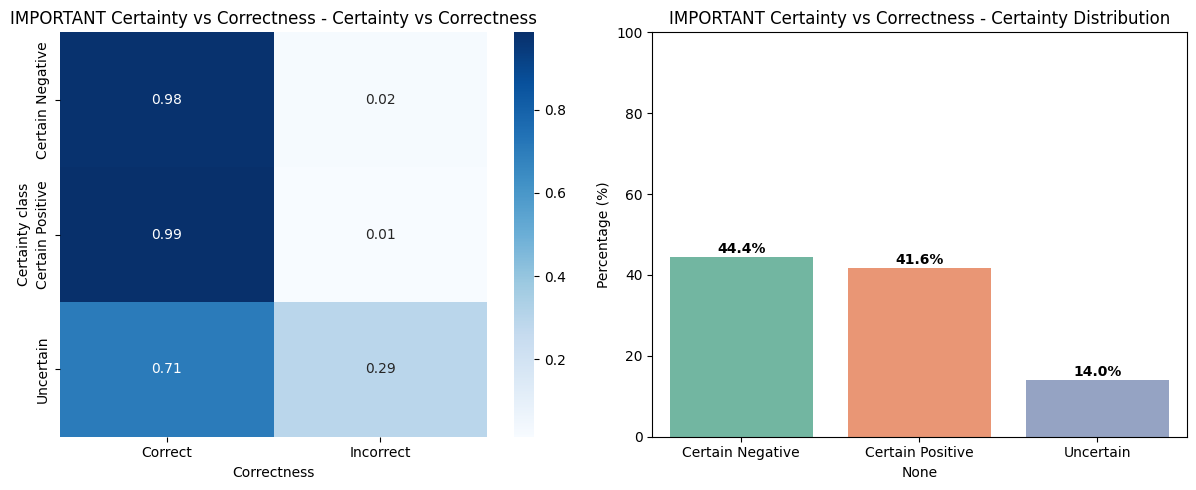


IMPORTANT MODEL - Unsure Predictions (probability near 0.3-0.7):
Probability [0.64], Label [1]: "Brilliant movie. The drawings were just amazing. Too bad it ended before it begun. I´ve waited 21 years for a sequel, but nooooo!!!"
Probability [0.69], Label [1]: "I got a good laugh reading all the idiotic comments for this film,<br /><br />as it's obvious that those people who criticized the movie never seen it, or were stupid enough to pay to see it.<br /><br />The best reason to watch was on the Elvira show a few years back. Elvira delivered the movie with as many laughs as one can.<br /><br />It's an ok monster flick, compared to the hundreds of horrendous American flicks made. Way better!!!!"
Probability [0.36], Label [0]: "Nobody, but nobody, could chew the scenery like the Divine One, Ruth Elizabeth Davis, and "Elizabeth and Essex" is a great example why. Although she overplays the part at times, watch her when she gawfs about Raliegh writing the lyrics to a song her ladies-in-wai

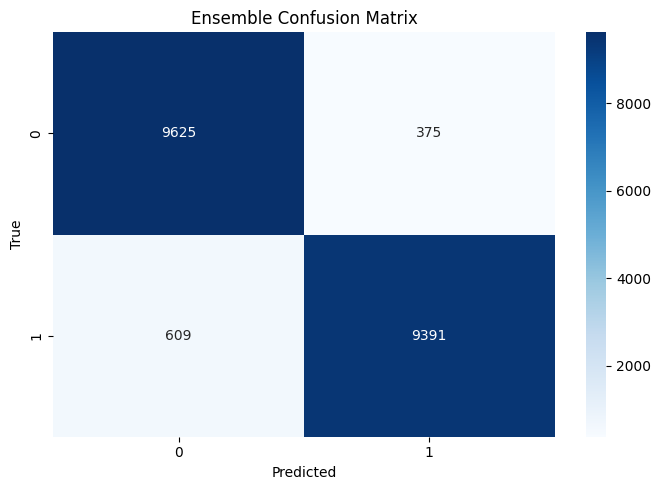

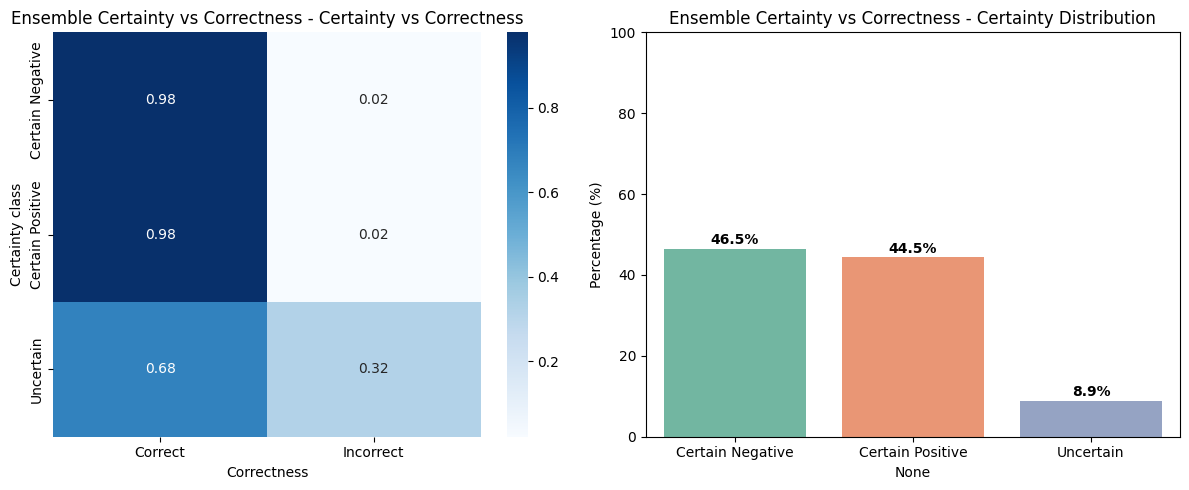


ENSEMBLE - Unsure Predictions (probability near 0.3-0.7):
Probability [0.64], Label [1]: "Ah, I loved this movie. I think it had it all. It made me laugh out loud over a dozen of times. Yes, I am a girl, so I'm writing this from a girl's perspective. I think it's a shame it only scored 5.2 in rating. Too many guys voting? It was far above other romantic comedies. Just because I'm female I don't enjoy all chic flicks, on the contrary I prefer other genres. Romantic comedies tend to be shallow and not as funny as they meant to be. But like I said, this movie had it all, almost, in my opinion. Great script, good one-liners, fine acting. Although Eva Longoria Parker's character reminded very much of Gabrielle from Desperate Housewives, but so what? It was awesome. I will keep this film for rainy days, days when I feel low and need a few laughs."
Probability [0.51], Label [1]: "In the previews, "The 40 Year-Old Virgin" boasts the image of another immature sex romp about a 40-ish Lonely Guy

In [18]:
results = run_experiment(X_sets_train, y_train, X_sets_test, y_test, test_df["review"], "linear-svm")